# Principal component analysis of NEMO surface tracers

Figs. 6-7 and S2 from:

>B. Moore-Maley and S. E. Allen: Wind-driven upwelling and surface nutrient delivery in a semi-enclosed coastal sea, Ocean Sci., 2022.

Description:

Empirical orthogonal function (EOF) spatial anomalies in order of decreasing percent variance applied to the 2015-2019 SalishSeaCast surface temperature and nitrate records during the productive season. Also included are the PC loadings time series for the nitrate upwelling modes.

***

In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt, dates
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from datetime import datetime
from roman import toRoman

import tools

%matplotlib inline

In [2]:
plt.rcParams['font.size'] = 12

***

### Load data

In [3]:
# erddap mask and variables
with xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn3DMeshMaskV17-02') as mask:
    gridx, gridy = [mask[var].values for var in ('gridX', 'gridY')]
    tmask = mask.tmask[0, 0, ...].values

# NEMO aggregation results
with xr.open_dataset(f'/path/to/files/MooreMaleyAllenOS2022_modelfields.nc') as ds:
    time = tools.formattime(ds.time.values)
    v_along = tools.lowpass(ds.v_along.values, 25)

# PCA results
ds = {var: xr.open_dataset(f'/path/to/files/{var}_PCA.nc') for var in ('temperature', 'nitrate')}

***

### Figures

Plotting functions

In [4]:
def scalebar(ax, size, label, loc=3):
    """
    """

    scalebar = AnchoredSizeBar(
        ax.transData, size, label, loc=loc,
        pad=0.4, borderpad=0.2, size_vertical=2,
    )
    ax.add_artist(scalebar)


def make_panel(
    ax, field, title, clim=None, ticklim=None, units=None,
    cmap='RdBu_r', extend='both', colorbar=False,
):
    """
    """
    
    # Parse clim to levels
    levels = None if clim == None else np.arange(*clim)
    
    # Plot fields
    c = ax.contourf(ds['temperature'].x, ds['temperature'].y, field, levels=levels, cmap=cmap, extend=extend)
    ax.set_title(title, fontsize=12)
    for C in c.collections: C.set_edgecolor('face') # remove line artifacts
    
    # Add colorbar
    if colorbar:
        
        # Parse clim to ticks and add colorbar
        ticks = None if ticklim == None else np.arange(*ticklim)
        pos = ax.get_position()
        cax = fig.add_axes([pos.x1, pos.y0, 0.015, pos.height])
        cbar = fig.colorbar(c, cax=cax, ticks=ticks)
        cbar.ax.set_title(f'[{units}]', fontsize=12, y=1.05)
        cbar.solids.set_edgecolor('face') # remove line artifacts
    
    # Formatting
    ax.contourf(gridx, gridy, tmask, levels=[-0.01, 0.01], colors='lightgray')
    ax.contour(gridx, gridy, tmask, levels=[-0.01, 0.01], colors='k')
    ax.set_xlim([110, 370])
    ax.set_ylim([300, 850])
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.set_aspect(5/4.4)

Median tracer fields and dominant EOF spatial patterns (Fig. 6)

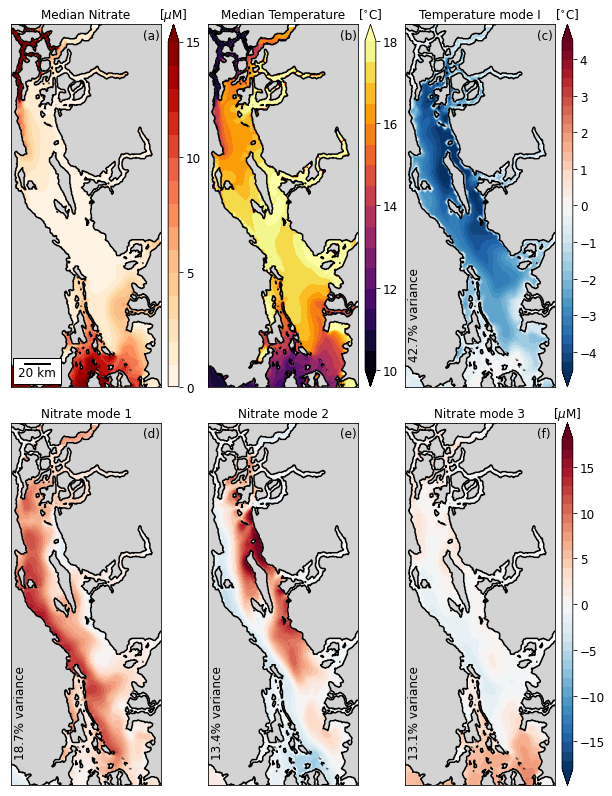

In [5]:
# Make figure and plotting params
fig, axs = plt.subplots(2, 3, figsize=(10, 14), gridspec_kw={'wspace': 0.2, 'hspace': 0.1})

# Plot median nitrate
make_panel(
    axs[0, 0], ds['nitrate']['median'], 'Median Nitrate', clim=(0, 15.1, 1),
    ticklim=(0, 15.1, 5), units='$\mu$M', cmap='OrRd', extend='max', colorbar=True,
)

# Plot median temperature
make_panel(
    axs[0, 1], ds['temperature']['median'], 'Median Temperature', clim=(10, 18.1, 0.5),
    ticklim=(10, 18.1, 2), units='$^{\circ}$C', cmap='inferno', extend='both', colorbar=True,
)

# Plot temperate mode I
norm = -np.percentile(abs(ds['temperature']['B'][:, 0]), 99.9)
make_panel(
    axs[0, 2], ds['temperature']['U'][..., 0] * norm, 'Temperature mode I',
    clim=(-4.5, 4.6, 0.25), ticklim=(-4, 5, 1), units='$^{\circ}$C', colorbar=True,
)
variance = ds['temperature']['var_rot'][0].values * 100
axs[0, 2].text(0.02, 0.08, f'{variance:.01f}% variance', rotation=90, transform=axs[0, 2].transAxes)

# Plot nitrate modes
for ax, mode, sign in zip(axs[1, :], range(3), [-1, 1, 1]):
    colorbar = True if mode == 2 else False
    norm = sign * np.percentile(abs(ds['nitrate']['B'][:, mode]), 99.9)
    make_panel(
        ax, ds['nitrate']['U'][..., mode] * norm, f'Nitrate mode {mode+1}',
        clim=(-18, 19, 1), ticklim=(-15, 16, 5), units='$\mu$M', colorbar=colorbar,
    )
    variance = ds['nitrate']['var_rot'][mode].values * 100
    ax.text(0.02, 0.08, f'{variance:.01f}% variance', rotation=90, transform=ax.transAxes)

# Add scalebar and panel letters
scalebar(axs[0, 0], 45, '20 km')
for ax, k in zip(axs.ravel(), range(6)):
    ax.text(0.88, 0.96, f'({chr(97+k)})', transform=ax.transAxes)

First five EOF spatial patterns (Fig. S2)

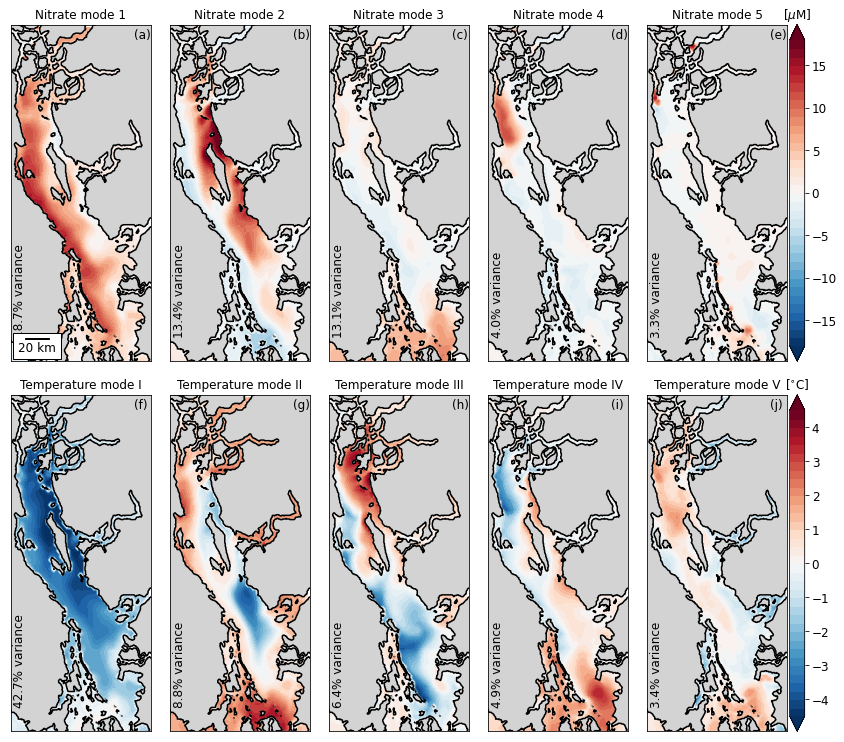

In [6]:
# Make figure and plotting params
fig, axs = plt.subplots(2, 5, figsize=(14, 13), gridspec_kw={'wspace': 0.1, 'hspace': 0.1})

# Plot nitrate and temperature modes
variables, units = ['nitrate', 'temperature'], ['$\mu$M', '$^{\circ}$C']
clims, ticklims = [(-18, 19, 1), (-4.5, 4.6, 0.25)], [(-15, 16, 5), (-4, 5, 1)]
signlist = [(-1, 1, 1, -1, -1), (-1, -1, 1, 1, 1)]
for row, var, unit, clim, ticklim, signs in zip(axs, variables, units, clims, ticklims, signlist):
    for ax, mode, sign in zip(row, range(5), signs):
        colorbar = True if mode == 4 else False
        norm = sign * np.percentile(abs(ds[var]['B'][:, mode]), 99.9)
        m = toRoman(mode + 1) if var == 'temperature' else mode + 1
        make_panel(
            ax, ds[var]['U'][..., mode] * norm, f'{var.capitalize()} mode {m}',
            clim=clim, ticklim=ticklim, units=unit, colorbar=colorbar,
        )
        variance = ds[var]['var_rot'][mode].values * 100
        ax.text(0.02, 0.08, f'{variance:.01f}% variance', rotation=90, transform=ax.transAxes)

# Add scalebar and panel letters
scalebar(axs[0, 0], 45, '20 km')
for ax, k in zip(axs.ravel(), range(10)):
    ax.text(0.88, 0.96, f'({chr(97+k)})', transform=ax.transAxes)

### Principle component time series

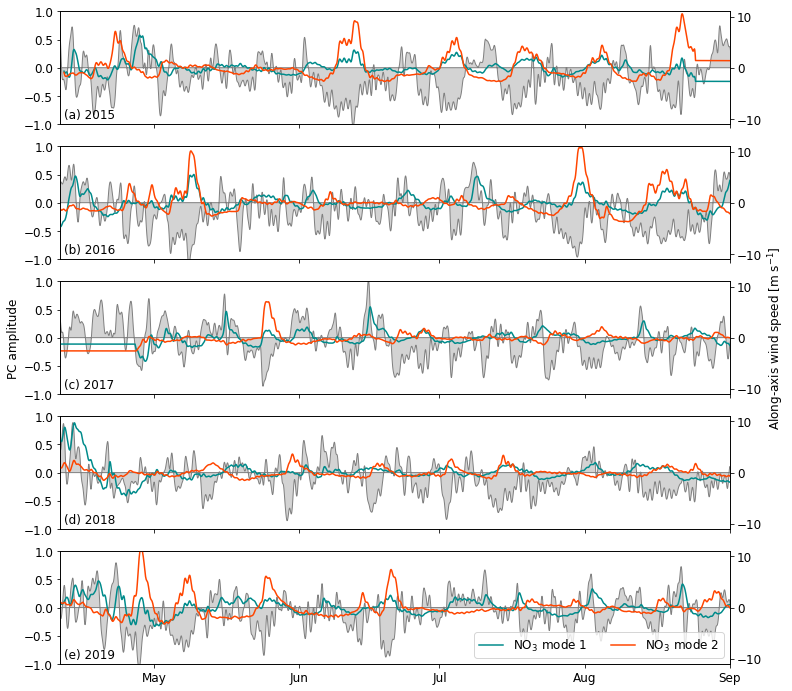

In [7]:
fig, axs = plt.subplots(5, 1, figsize=(12, 12), gridspec_kw={'wspace': 0.05})

for ax, year in zip(axs, range(2015, 2020)):
    
    xlim = [datetime(year, *md) for md in [(4, 11), (9, 1)]]

    # Formatting
    ax_left = ax
    ax_left.patch.set_visible(False)
    ax_left.set_zorder(1)
    ax_left.set_xlim(xlim)
    ax_left.set_ylim([-1, 1])
    ax_left.xaxis.set_major_locator(dates.MonthLocator())
    ax_left.xaxis.set_major_formatter(dates.DateFormatter('%b'))
    if year < 2019: ax_left.xaxis.set_ticklabels('')
    ax_right = ax_left.twinx()
    ax_right.patch.set_visible(True)
    ax_right.set_ylim([-11, 11])
    if year == 2017:
        ax_left.set_ylabel('PC amplitude')
        ax_right.set_ylabel('Along-axis wind speed [m s$^{-1}$]')

    # Plot NO3 PCs
    for mode, color, sign in zip([0, 1], ['darkcyan', 'orangered'], [-1, 1]):
        norm = sign * np.percentile(abs(ds['nitrate']['B'][:, mode]), 99.9)
        PC = tools.lowpass(ds['nitrate']['B'][:, mode] / norm, 25)
        ax_left.plot(ds['nitrate'].time, PC, '-', color=color, label=f'NO$_3$ mode {mode+1}')

    # Plot wind
    ax_right.fill_between(time, v_along, ec='gray', fc='lightgray', label='HRDPS')
    
    # Make plot label
    ax_left.text(0.005, 0.05, f'({chr(year-1918)}) {year}', transform=ax_left.transAxes)

axs[4].legend(loc=4, ncol=2)